# Perceived irrelevance: analysis

This notebook contains all the analysis and data preparation steps for generating the results and figures of the analysis.

## BIDS conversion
Converting the data from the format specific to our implementation in labVanced to a bids-like format for convenience of processing. In our experiment, part of the data were collected in the lab, while the rest was collected online. This information is added to the participants.tsv for later reference

In [1]:
# Convert the data to BIDS
from config import source_root, bids_root, colors
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binomtest, fisher_exact

from bids_conversion import beh_cleanup, get_demo, get_subjects_list, dataframe2bids, exclusion_criterion, count_trailing_zeros_after_decimal

# Specify the name of the task:
task = 'PerceivedIrrelevance'

# Prepare participants.tsv:
participants = pd.DataFrame(columns=['participant_id', 'sex', 'age', 'online'])

# List all lab participants
lab_root = Path(source_root, 'labExperiment', 'rawDataLab')
lab_participants = get_subjects_list(lab_root)

for participant in lab_participants:
    # Load the data and clean up the data to a format that is compatible to the BIDS standards:
    events_log = beh_cleanup(lab_root, participant)
    # Apply exclusion criterion:
    excluded = exclusion_criterion(events_log)
    # Save it to a tsv file:
    dataframe2bids(events_log, bids_root, participant, task, data_type='beh', json_sidecar=None)
    # Get the demographic info for that subject:
    age, gender = get_demo(lab_root, participant)
    # Add the participant info:
    participants = pd.concat([participants, pd.DataFrame({
        'participant_id': participant,
        'sex': gender,
        'age': age,
        'online': False,
        'excluded': excluded
    }, index=[0])], ignore_index=True)

# List all online participants
online_root = Path(source_root, 'onlineExperiment', 'rawData')
online_participants = get_subjects_list(online_root)

for participant in online_participants:
    # Load the data and clean up the data to a format that is compatible to the BIDS standards:
    events_log = beh_cleanup(online_root, participant)
    # Apply exclusion criterion:
    excluded = exclusion_criterion(events_log)
    # Save it to a tsv file:
    dataframe2bids(events_log, bids_root, participant, 'PerceivedIrrelevance', data_type='beh', json_sidecar=None)
    # Get the demographic info for that subject:
    age, gender = get_demo(online_root, participant)
    # Add the participant info:
    participants = pd.concat([participants, pd.DataFrame({
        'participant_id': participant,
        'sex': gender,
        'age': age,
        'online': True,
        'excluded': excluded
    }, index=[0])], ignore_index=True)

# Save the participants table:
file_name_demo = "participants.tsv"
file_path_demo = Path(bids_root, file_name_demo)

# Save the DataFrame to TSV format
participants.to_csv(file_path_demo, sep='\t', index=False)


c:\Users\alexander.lepauvre\Documents\GitHub\perceiveIrrelevance_experiment\python\bids_conversion.py:429: UserWarning: A JSON sidecar is recommended but was not provided.
  warnings.warn("A JSON sidecar is recommended but was not provided.")
c:\Users\alexander.lepauvre\Documents\GitHub\perceiveIrrelevance_experiment\python\bids_conversion.py:429: UserWarning: A JSON sidecar is recommended but was not provided.
  warnings.warn("A JSON sidecar is recommended but was not provided.")
c:\Users\alexander.lepauvre\Documents\GitHub\perceiveIrrelevance_experiment\python\bids_conversion.py:429: UserWarning: A JSON sidecar is recommended but was not provided.
  warnings.warn("A JSON sidecar is recommended but was not provided.")
c:\Users\alexander.lepauvre\Documents\GitHub\perceiveIrrelevance_experiment\python\bids_conversion.py:429: UserWarning: A JSON sidecar is recommended but was not provided.
  warnings.warn("A JSON sidecar is recommended but was not provided.")
c:\Users\alexander.lepauvre\

## Demographics
Computing descriptive statistics of our participants:

In [2]:
# Load the demographic data:
participants_demo = pd.read_csv(file_path_demo, sep='\t')
print(participants_demo.head())

  participant_id     sex   age  online  excluded
0         Sub101  female  24.0   False     False
1         Sub102  female  28.0   False     False
2         Sub103    male  27.0   False     False
3         Sub104  female  25.0   False     False
4         Sub105    male  25.0   False     False


In [3]:
# Compute participants mean age and standard deviation:
n_females = participants_demo[participants_demo['sex'] == 'female'].shape[0]
mean_age = round(participants_demo['age'].mean(), 2)
std_dev_age = round(participants_demo['age'].std(), 2)
print(f'N Females={n_females}, aged {mean_age} ± {std_dev_age}')

N Females=30, aged 27.24 ± 4.32


In [4]:
# Compute age of in lab participants:
n_females = participants_demo[(participants_demo['online'] == False) & (participants_demo['sex'] == 'female')].shape[0]
mean_age = round(participants_demo[participants_demo['online'] == False]['age'].mean(), 2)
std_dev_age = round(participants_demo[participants_demo['online'] == False]['age'].std(), 2)
print(f'N Females={n_females}, aged {mean_age} ± {std_dev_age}')

N Females=10, aged 26.43 ± 2.54


In [5]:
# Compute age of online participants:
n_females = participants_demo[(participants_demo['online'] == True) & (participants_demo['sex'] == 'female')].shape[0]
mean_age = round(participants_demo[participants_demo['online'] == True]['age'].mean(), 2)
std_dev_age = round(participants_demo[participants_demo['online'] == True]['age'].std(), 2)
print(f'N Females={n_females}, aged {mean_age} ± {std_dev_age}')

N Females=20, aged 27.62 ± 4.93


## Analysis
Loading the data of each participants, excluding those that did not pass the exclusion criterion:

In [6]:
# Load the data of all subjects:
subjects_df = []
for sub in participants_demo['participant_id'].to_list():
    if participants_demo.loc[participants_demo['participant_id'] == sub, 'excluded'].values[0]:
        print(f'Subject {sub} excluded')
        continue
    # Load the events.tsv:
    file_path = Path(bids_root, sub, 'beh', f'{sub}_task-{task}_events.tsv')
    subject_df = pd.read_csv(file_path, sep='\t')
    # Add wheter the subject was collected in the lab or not for later reference:
    subject_df['online'] = participants_demo.loc[participants_demo['participant_id'] == sub, 'online'].values[0]
    # Add subject id for later reference:
    subject_df['participant_id'] = sub
    subjects_df.append(subject_df)
subjects_df = pd.concat(subjects_df, ignore_index=True)

### Surprise trial analysis:

The main research question of this experiment is whether participants can remember task irrelevant features: orientation and duration. Importantly, we have two groups of participants: half were presented a face as surprise trials, others were presented an object. It is likely that memory performance differ between these two types of stimuli. Accordingly, we will assess the memory performance separately for the faces and objects by comparing the memory performances against chance using a binomial test. To test whether a difference between face and objects exist, we will compare the memory performance between both conditions separately of the duration and memory probe using a Fisher exact's test. In addition, a subset of participants was collected in the lab, while the rest was collected online. We will first analyse them separately before combining them.

In [7]:
# Extract the results of the surprise probe for orientation and duration separately:
surprise_probe_data = subjects_df[(subjects_df['block_type'] == 'surprise') & 
                                  ((subjects_df['event_type'] == 'probe_duration') | 
                                   (subjects_df['event_type'] == 'probe_orientation'))].reset_index(drop=True)
surprise_probe_data.to_csv('surprise.csv')

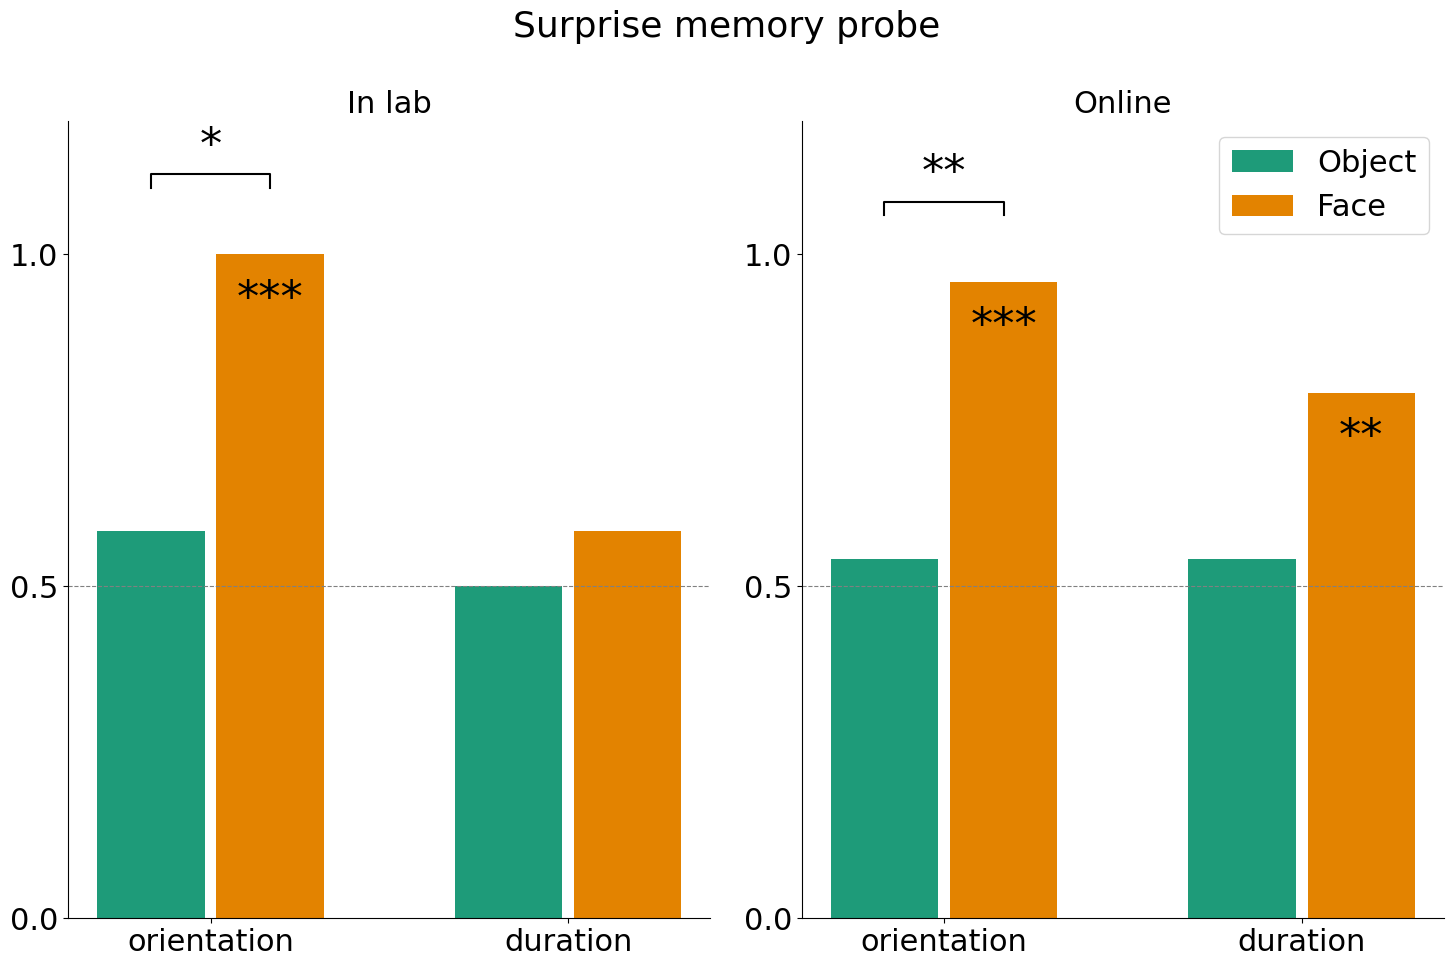

In [8]:
# Investigate separately the online and in lab results:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
# Plot separately in lab and online
online_flags = [False, True]
# Plot separately results from each probe
probe_types = ['orientation', 'duration']
# Plot separately results from faces and objects groups:
target_groups = ['Object', 'Face']
bar_width = 0.9
for i, online in enumerate(online_flags):
    ctr = 0
    for ii, prb in enumerate(probe_types):
        tbl = np.zeros((2, 2))
        for iii, grp in enumerate(target_groups):
            # Extract the data with this particular combination of conditions:
            df = surprise_probe_data[(surprise_probe_data['online'] == online) &
                            (surprise_probe_data['event_type'] == f'probe_{prb}') &
                            (surprise_probe_data['target_group'] == grp)]
            # Check whether their response matches what's expected
            if prb == 'duration':
                data = df['duration_str'].to_numpy() == df['response'].to_numpy()
            else:
                data = df['orientation'].to_numpy() == df['response'].to_numpy()

            # Binomial test:
            res = binomtest(np.sum(data), data.shape[0], alternative='greater')

            # Populate the contingency table to compare the two groups:
            tbl[iii, 0] = np.sum(data)
            tbl[iii, 1] = data.shape[0] - np.sum(data) 

            # Plot the results:
            bar_height = np.sum(data) / data.shape[0]
            x_pos = ctr + ii
            ax[i].bar(x_pos,  bar_height, color=colors[grp.lower()], width=bar_width, label=grp if ii == 0 else "")
            if res.pvalue < 0.05:
                # Set the asterisk:
                sig_lvl = '***' if count_trailing_zeros_after_decimal(res.pvalue) > 4 else '*' * count_trailing_zeros_after_decimal(res.pvalue)
                ax[i].text(x_pos, bar_height - 0.1, sig_lvl, ha='center', va='bottom', fontsize=32, color='k')
            
            # Add significance mark:
            ctr += 1

        # Fisher exact test between both conditions:
        res = fisher_exact(tbl)
        if res.pvalue < 0.05:
            x1 = ctr - 2  # Position of the first bar (Object)
            x2 = ctr - 1  # Position of the second bar (Face)
            y = max(tbl[:, 0] / tbl.sum(axis=1)) + 0.1  # Height for the significance line
            ax[i].plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], color='black')
            # Set the asterisk:
            sig_lvl = '***' if count_trailing_zeros_after_decimal(res.pvalue) > 3 else '*' * count_trailing_zeros_after_decimal(res.pvalue)
            ax[i].text((x1 + x2) / 2, y + 0.03, sig_lvl, ha='center', va='bottom', fontsize=32, color='k')

    # Customize each subplot
    if online:
        ax[i].set_title(f'Online')
    else:
        ax[i].set_title(f'In lab')
    ax[i].set_xticks([0.5, 3.5])
    ax[i].set_xticklabels(probe_types)
    ax[i].spines[['right', 'top']].set_visible(False)
    # Set y-axis limits and ticks, with a dashed line at 0.5
    ax[i].set_ylim(0, 1.2)
    ax[i].set_yticks([0, 0.5, 1])
    ax[i].axhline(0.5, color='gray', linestyle='--', linewidth=0.8)

plt.suptitle('Surprise memory probe')
plt.legend()
plt.tight_layout()
plt.show()
plt.show()


These results highlight that participants are best at remembering orientation of faces, both in the online and in lab experiment. Participants are significantly better at remembering faces orientation than they are at remembering objects orientation. In fact, participants were not able to remember objects orientation above chance at all. Regarding duration, participants seemed to be able to remember it for the faces stimuli, though the results are inconsistent between the in lab and online study. Participants were not able to remember duration of objects stimuli. 

As the result of both studies align, we can combine them to obtain more statistical power. 

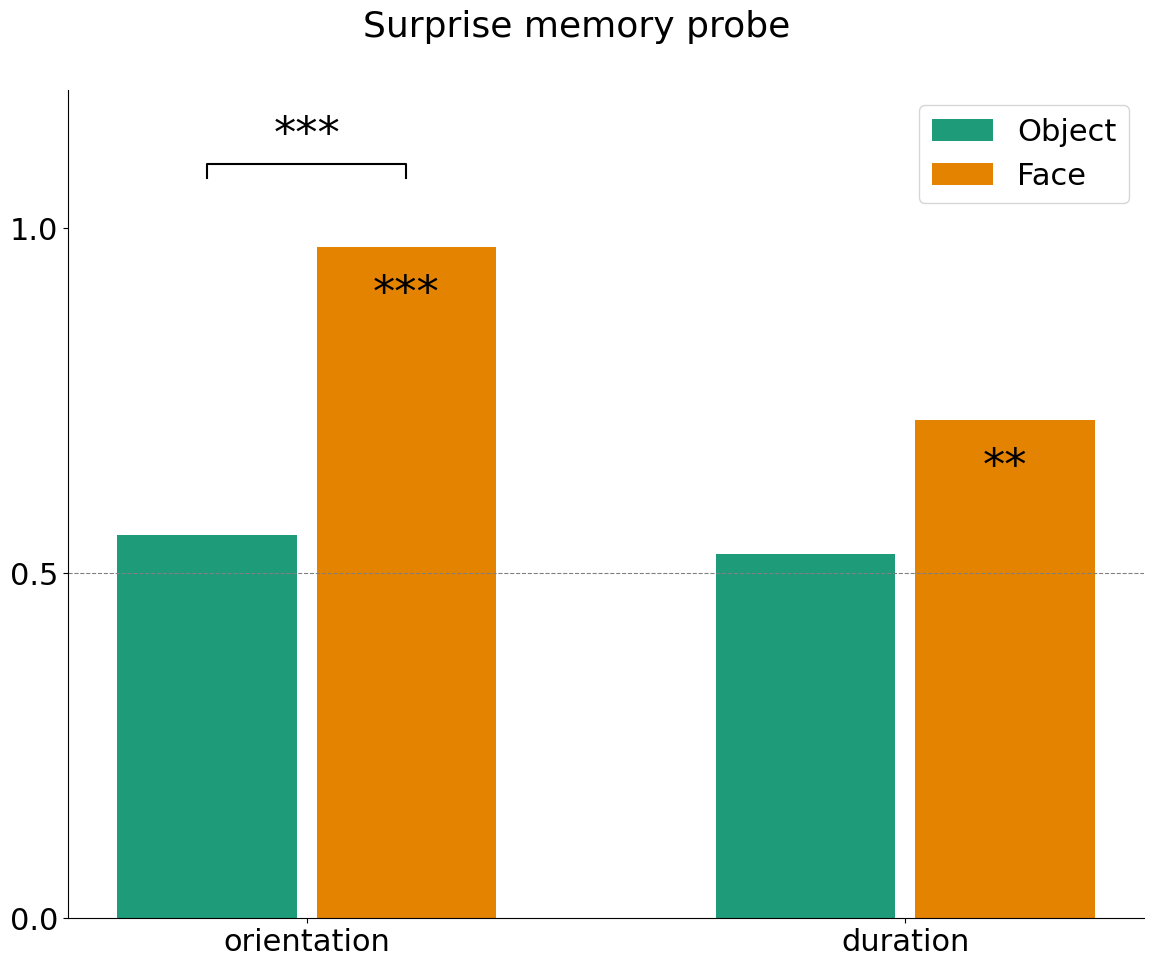

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot separately results from each probe
probe_types = ['orientation', 'duration']
# Plot separately results from faces and objects groups:
target_groups = ['Object', 'Face']
bar_width = 0.9
offset = bar_width + bar_width * 0.2
ctr = 0
for ii, prb in enumerate(probe_types):
    tbl = np.zeros((2, 2))
    for iii, grp in enumerate(target_groups):
        # Extract the data with this particular combination of conditions:
        df = surprise_probe_data[(surprise_probe_data['event_type'] == f'probe_{prb}') &
                        (surprise_probe_data['target_group'] == grp)]
        # Check whether their response matches what's expected
        if prb == 'duration':
            data = df['duration_str'].to_numpy() == df['response'].to_numpy()
        else:
            data = df['orientation'].to_numpy() == df['response'].to_numpy()

        # Populate the contingency table to compare the two groups:
        tbl[iii, 0] = np.sum(data)
        tbl[iii, 1] = data.shape[0] - np.sum(data) 

        # Binomial test:
        res = binomtest(np.sum(data), data.shape[0], alternative='greater')

        # Plot the results:
        bar_height = np.sum(data) / data.shape[0]
        x_pos = ctr + ii
        ax.bar(x_pos,  bar_height, color=colors[grp.lower()], width=bar_width, label=grp if ii == 0 else "")
        if res.pvalue < 0.05:
            # Set the asterisk:
            sig_lvl = '***' if count_trailing_zeros_after_decimal(res.pvalue) > 4 else '*' * count_trailing_zeros_after_decimal(res.pvalue)
            ax.text(x_pos, bar_height - 0.1, sig_lvl, ha='center', va='bottom', fontsize=32, color='k')
        
        # Add significance mark:
        ctr += 1
    
    # Fisher exact test between both conditions:
    res = fisher_exact(tbl)
    if res.pvalue < 0.05:
        x1 = ctr - 2  # Position of the first bar (Object)
        x2 = ctr - 1  # Position of the second bar (Face)
        y = max(tbl[:, 0] / tbl.sum(axis=1)) + 0.1  # Height for the significance line
        ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], color='black')
        # Set the asterisk:
        sig_lvl = '***' if count_trailing_zeros_after_decimal(res.pvalue) > 3 else '*' * count_trailing_zeros_after_decimal(res.pvalue)
        ax.text((x1 + x2) / 2, y + 0.03, sig_lvl, ha='center', va='bottom', fontsize=32, color='k')
        
# Customize each subplot
ax.set_xticks([0.5, 3.5])
ax.set_xticklabels(probe_types)
ax.spines[['right', 'top']].set_visible(False)
# Set y-axis limits and ticks, with a dashed line at 0.5
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.5, 1])
ax.axhline(0.5, color='gray', linestyle='--', linewidth=0.8)

plt.suptitle('Surprise memory probe')
plt.legend()
plt.tight_layout()
plt.show()
plt.show()


In the combined data set, we observe that participants are able to remember both orientation and duration, but only when the presented stimulus was a face. Participants are significantly better at remembering face orientation than object orientation. The difference between faces and objects is not significant for duration, which may be due to the effect size being smaller, as memory performances for faces duration is also lower.

### Order effect:
In our task, in order to avoid order effects, we counter-balanced which of the two features is asked first across participants. However, it is likely that task irrelevant features decay from memory rather fast, in which case the likelihood of a feature being remembered depends on whether the probe appeared first or second. To investigate this possibility, we compared the memory performance of each feature for each stimulus category separately depending on whether the probe occured first or not:

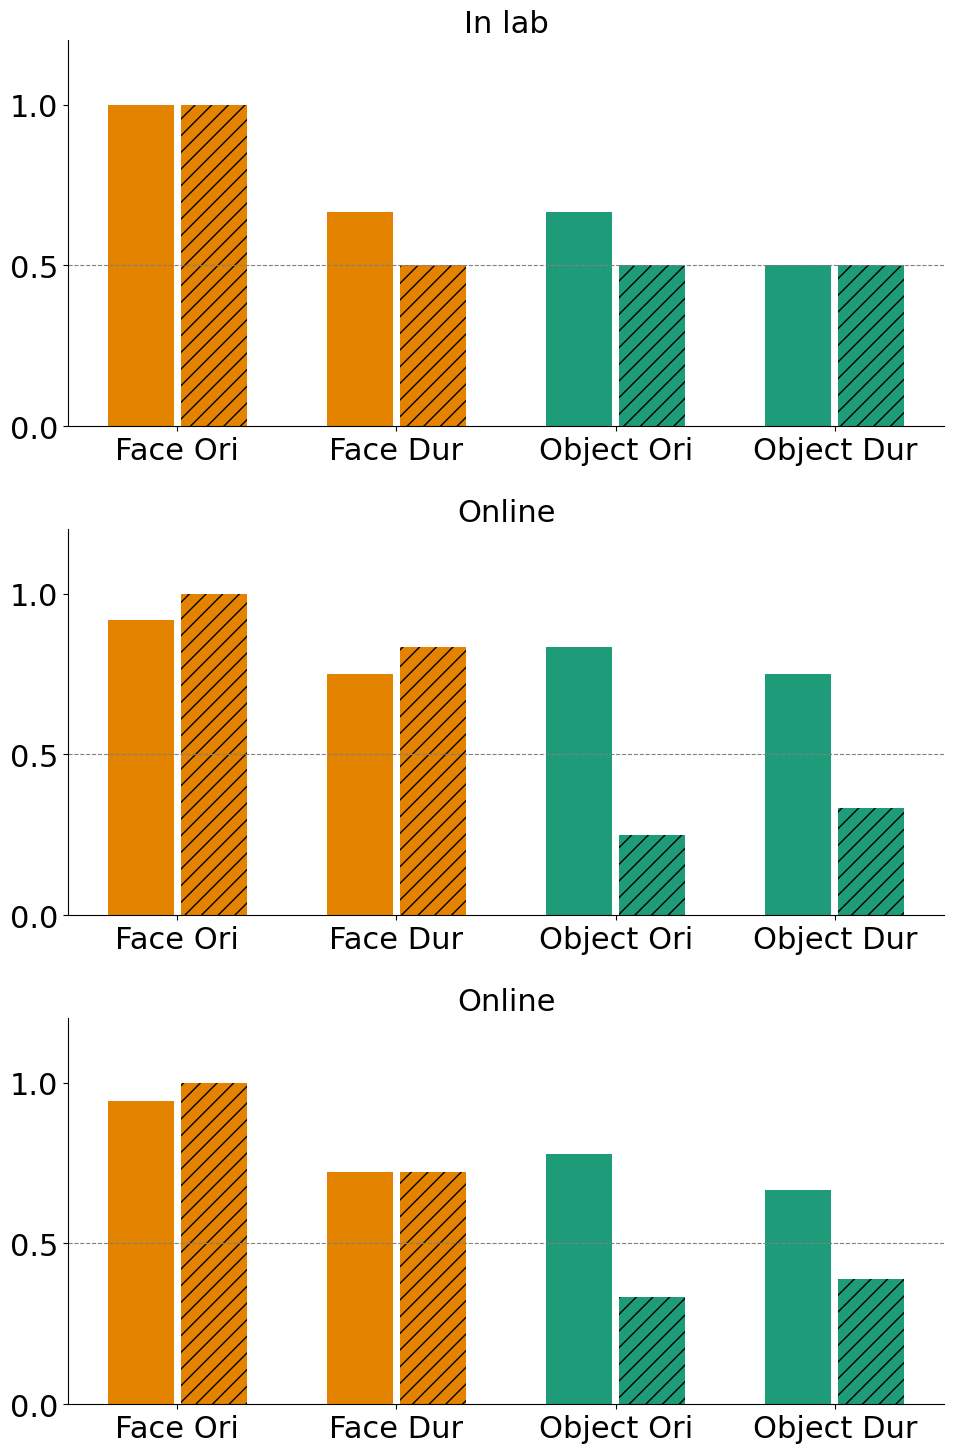

In [50]:
# Investigate the order effect:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# In lab study face orientation:
for i, online in enumerate(online_flags):
    ctr = 0
    for ii, grp in enumerate(['Face', 'Object']):
        for iii, prb in enumerate(['probe_orientation', 'probe_duration']):
            ctr += 1
            tbl = np.zeros((2, 2))
            if prb == 'probe_orientation':
                order = ['orientationFirst', 'durationFirst']
            else:
                order = ['durationFirst', 'orientationFirst']
            lgd = ['first', 'second']
            for iiii, ord in enumerate(order):
                df = surprise_probe_data[(surprise_probe_data['online'] == online) &
                                            (surprise_probe_data['event_type'] == prb) &
                                            (surprise_probe_data['target_group'] == grp) & 
                                            (surprise_probe_data['probe_order'] == ord)]
                # Extract probed first:
                if prb == 'probe_orientation':
                    data = df['orientation'].to_numpy() == df['response'].to_numpy()
                else:
                    data = df['duration_str'].to_numpy() == df['response'].to_numpy()
                # Populate the contingency table to compare the two groups:
                tbl[iii, 0] = np.sum(data)
                tbl[iii, 1] = data.shape[0] - np.sum(data) 
                # Plot the results:
                bar_height = np.sum(data) / data.shape[0]
                if iiii == 0:
                    ax[i].bar(ctr, bar_height, color=colors[grp.lower()], width=bar_width, label=lgd[iiii])
                else:
                    ax[i].bar(ctr, bar_height, color=colors[grp.lower()], width=bar_width, hatch='//')
                ctr += 1
            
            # Fisher exact test between both conditions:
            res = fisher_exact(tbl)
            if res.pvalue < 0.05:
                x1 = ctr - 2  # Position of the first bar (Object)
                x2 = ctr - 1  # Position of the second bar (Face)
                y = max(tbl[:, 0] / tbl.sum(axis=1)) + 0.1  # Height for the significance line
                ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], color='black')
                # Set the asterisk:
                sig_lvl = '***' if count_trailing_zeros_after_decimal(res.pvalue) > 3 else '*' * count_trailing_zeros_after_decimal(res.pvalue)
                ax.text((x1 + x2) / 2, y + 0.03, sig_lvl, ha='center', va='bottom', fontsize=32, color='k')
            
        # Customize each subplot
    if online:
        ax[i].set_title(f'Online')
    else:
        ax[i].set_title(f'In lab')
    ax[i].set_xticks([1.5, 4.5, 7.5, 10.5])
    ax[i].set_xticklabels(['Face Ori', 'Face Dur', 'Object Ori', 'Object Dur'])
    ax[i].spines[['right', 'top']].set_visible(False)
    # Set y-axis limits and ticks, with a dashed line at 0.5
    ax[i].set_ylim(0, 1.2)
    ax[i].set_yticks([0, 0.5, 1])
    ax[i].axhline(0.5, color='gray', linestyle='--', linewidth=0.8)

# Combined
i = 2
ctr = 0
for ii, grp in enumerate(['Face', 'Object']):
    for iii, prb in enumerate(['probe_orientation', 'probe_duration']):
        ctr += 1
        tbl = np.zeros((2, 2))
        if prb == 'probe_orientation':
            order = ['orientationFirst', 'durationFirst']
        else:
            order = ['durationFirst', 'orientationFirst']
        lgd = ['first', 'second']
        for iiii, ord in enumerate(order):
            df = surprise_probe_data[(surprise_probe_data['event_type'] == prb) &
                                        (surprise_probe_data['target_group'] == grp) & 
                                        (surprise_probe_data['probe_order'] == ord)]
            # Extract probed first:
            if prb == 'probe_orientation':
                data = df['orientation'].to_numpy() == df['response'].to_numpy()
            else:
                data = df['duration_str'].to_numpy() == df['response'].to_numpy()
            # Populate the contingency table to compare the two groups:
            tbl[iii, 0] = np.sum(data)
            tbl[iii, 1] = data.shape[0] - np.sum(data) 
            # Plot the results:
            bar_height = np.sum(data) / data.shape[0]
            if iiii == 0:
                ax[i].bar(ctr, bar_height, color=colors[grp.lower()], width=bar_width, label=lgd[iiii])
            else:
                ax[i].bar(ctr, bar_height, color=colors[grp.lower()], width=bar_width, hatch='//')
            ctr += 1
        
        # Fisher exact test between both conditions:
        res = fisher_exact(tbl)
        if res.pvalue < 0.05:
            x1 = ctr - 2  # Position of the first bar (Object)
            x2 = ctr - 1  # Position of the second bar (Face)
            y = max(tbl[:, 0] / tbl.sum(axis=1)) + 0.1  # Height for the significance line
            ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], color='black')
            # Set the asterisk:
            sig_lvl = '***' if count_trailing_zeros_after_decimal(res.pvalue) > 3 else '*' * count_trailing_zeros_after_decimal(res.pvalue)
            ax.text((x1 + x2) / 2, y + 0.03, sig_lvl, ha='center', va='bottom', fontsize=32, color='k')
        
    # Customize each subplot
if online:
    ax[i].set_title(f'Online')
else:
    ax[i].set_title(f'In lab')
ax[i].set_xticks([1.5, 4.5, 7.5, 10.5])
ax[i].set_xticklabels(['Face Ori', 'Face Dur', 'Object Ori', 'Object Dur'])
ax[i].spines[['right', 'top']].set_visible(False)
# Set y-axis limits and ticks, with a dashed line at 0.5
ax[i].set_ylim(0, 1.2)
ax[i].set_yticks([0, 0.5, 1])
ax[i].axhline(0.5, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()
plt.close()

There seems to be a trend, such that the features asked second are remembered slightly worst, but it is not a very clear effect and the fisher exact test is not significant. It is not too surprising, as we have very few observation in each group. If anything, the effect seems to be most consistent for objects